In [1]:
### Regex to change quarters to datetime
import datetime as date
from matplotlib import pyplot as plt

def quarter_to_datetime(row):
    dates = {"Q1": "1/1", "Q2":"1/4", "Q3":"1/7", "Q4":"1/10"}
    string = row.replace("*", "").split(" ")[0]
    year, quarter = string[:4], string[4:]
    datetime_str = dates[quarter] + "/" + year
    return date.datetime.strptime(datetime_str, '%d/%m/%Y')

## With Geographical location

First we train a model for each postal codes. Postal codes do not have empty cells. Idea is to train model for each postal code and use geolocational information to match input with model. 

**For example, lets suppose we have postal code from otaniemi and it isnt in dataset. Therefore we cannot make model for it. However we can use a model which is located near to Otaniemi such as Tapiola for prediction. How? We calculate nearest postal code by using Otaniemi's latitude and longitude values.**

In [2]:
# Work in progress, fix when user input wrong type of value e.g. random text instead of postal code
# Disclaimer: df should contain latitude and longitude as well

def min_euclidean_distance(row, latitude, longitude):
    d2 = np.square( row.latitude - latitude )  + np.square( row.longitude - longitude) 
    return np.sqrt(d2)

def best_postal_code(df, latitude, longitude):
    df["euc"] = df.apply(lambda row: min_euclidean_distance(row, latitude, longitude), axis=1)

def find_nearest_postal_code(postal_code, df):
    df = df.copy()
    if postal_code not in df.columns and postal_code != "time": # "time" because our df contains that as index
        nomi = pgeocode.Nominatim('fi')
        location = nomi.query_postal_code([postal_code])
        latitude, longitude = location.latitude, location.longitude
        best_postal_code(df, latitude, longitude)
        best = df[df["euc"]==df["euc"].min()]["Postal code"].iloc[0]
        return best
        
    else:
        return postal_code

test_postal_code = "00530"

# After this make a model for postal code in result 

In [3]:
import datetime as date

def quarter_to_datetime(row):
    dates = {"Q1": "1/1", "Q2":"1/4", "Q3":"1/7", "Q4":"1/10"}
    string = row.replace("*", "").split(" ")[0]
    year, quarter = string[:4], string[4:]
    datetime_str = dates[quarter] + "/" + year
    return date.datetime.strptime(datetime_str, '%d/%m/%Y')

### Check correlation between postal codes in Finland

Lets check if postal codes have correlation between each other in terms of price

In [4]:
import pandas as pd


def wrangle_data(data):
    data = data.melt(id_vars=["Postal code", "Building type"],var_name="Quarter", value_name="EUR/m2")
    data["Quarter"] = data["Quarter"].apply(lambda row: quarter_to_datetime(row))
    data[['Postal code', 'Location']] = data['Postal code'].str.split(' ', 1, expand=True)
    return data

df_orig = pd.read_csv("../../data/quarterly_data.csv", encoding = 'unicode_escape')
df_wrangled = wrangle_data(df_orig)

In [5]:
df_wrangled.head()

,Postal code,Building type,Quarter,EUR/m2,Location
0,00100,"Blocks of flats, one-room flat",2010-01-01,5458,Helsinki Keskusta - Etu-Töölö (Helsinki )
1,00100,"Blocks of flats, two-room flat",2010-01-01,5164,Helsinki Keskusta - Etu-Töölö (Helsinki )
2,00100,"Blocks of flats, three-room flat+",2010-01-01,4944,Helsinki Keskusta - Etu-Töölö (Helsinki )
3,00100,Blocks of flats total,2010-01-01,5168,Helsinki Keskusta - Etu-Töölö (Helsinki )
4,00100,Terraced houses total,2010-01-01,..,Helsinki Keskusta - Etu-Töölö (Helsinki )


In [6]:
# Lets add geolocations to data
import pgeocode

postal_code_list = list(df_wrangled["Postal code"].unique())
nomi = pgeocode.Nominatim('fi')
location = nomi.query_postal_code(postal_code_list)

wanted_features_location = location[["postal_code", 
                                     "place_name", 
                                     "state_name", 
                                     "county_name", 
                                     "latitude", 
                                     "longitude"]]
wanted_features_location = wanted_features_location.rename(columns={"postal_code": "Postal code"})
df_wrangled = pd.merge(df_wrangled, wanted_features_location, on="Postal code")

In [7]:
df_wrangled.head()

,Postal code,Building type,Quarter,EUR/m2,Location,place_name,state_name,county_name,latitude,longitude
0,00100,"Blocks of flats, one-room flat",2010-01-01,5458,Helsinki Keskusta - Etu-Töölö (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1714,24.9316
1,00100,"Blocks of flats, two-room flat",2010-01-01,5164,Helsinki Keskusta - Etu-Töölö (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1714,24.9316
2,00100,"Blocks of flats, three-room flat+",2010-01-01,4944,Helsinki Keskusta - Etu-Töölö (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1714,24.9316
3,00100,Blocks of flats total,2010-01-01,5168,Helsinki Keskusta - Etu-Töölö (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1714,24.9316
4,00100,Terraced houses total,2010-01-01,..,Helsinki Keskusta - Etu-Töölö (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1714,24.9316


#### Lets examine correlation between different housing types

In [8]:
import numpy as np

def last_quarter_housing_type(data, building_type):
    one_room = data[data["Building type"].isin([building_type])]
    days = one_room[one_room["Quarter"].isin(["2021-04-01"])]
    days["EUR/m2"] = pd.to_numeric(data["EUR/m2"],errors='coerce')
    return days


building_type = "Blocks of flats, one-room flat"
df = last_quarter_housing_type(df_wrangled, building_type)
df.head()
#df[["Postal code", "EUR/m2"]].groupby(["Postal code"]).mean()["EUR/m2"].value_counts()

/var/folders/by/przz2wk900jdt2rj4vhw770h0000gn/T/ipykernel_56177/294769603.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  days["EUR/m2"] = pd.to_numeric(data["EUR/m2"],errors='coerce')


,Postal code,Building type,Quarter,EUR/m2,Location,place_name,state_name,county_name,latitude,longitude
270,00100,"Blocks of flats, one-room flat",2021-04-01,8596.0,Helsinki Keskusta - Etu-Töölö (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1714,24.9316
546,00120,"Blocks of flats, one-room flat",2021-04-01,NaN,Punavuori (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1632,24.9391
822,00130,"Blocks of flats, one-room flat",2021-04-01,NaN,Kaartinkaupunki (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1645,24.9487
1098,00140,"Blocks of flats, one-room flat",2021-04-01,NaN,Kaivopuisto - Ullanlinna (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1578,24.9525
1374,00150,"Blocks of flats, one-room flat",2021-04-01,9420.0,Eira - Hernesaari (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1570,24.9369


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

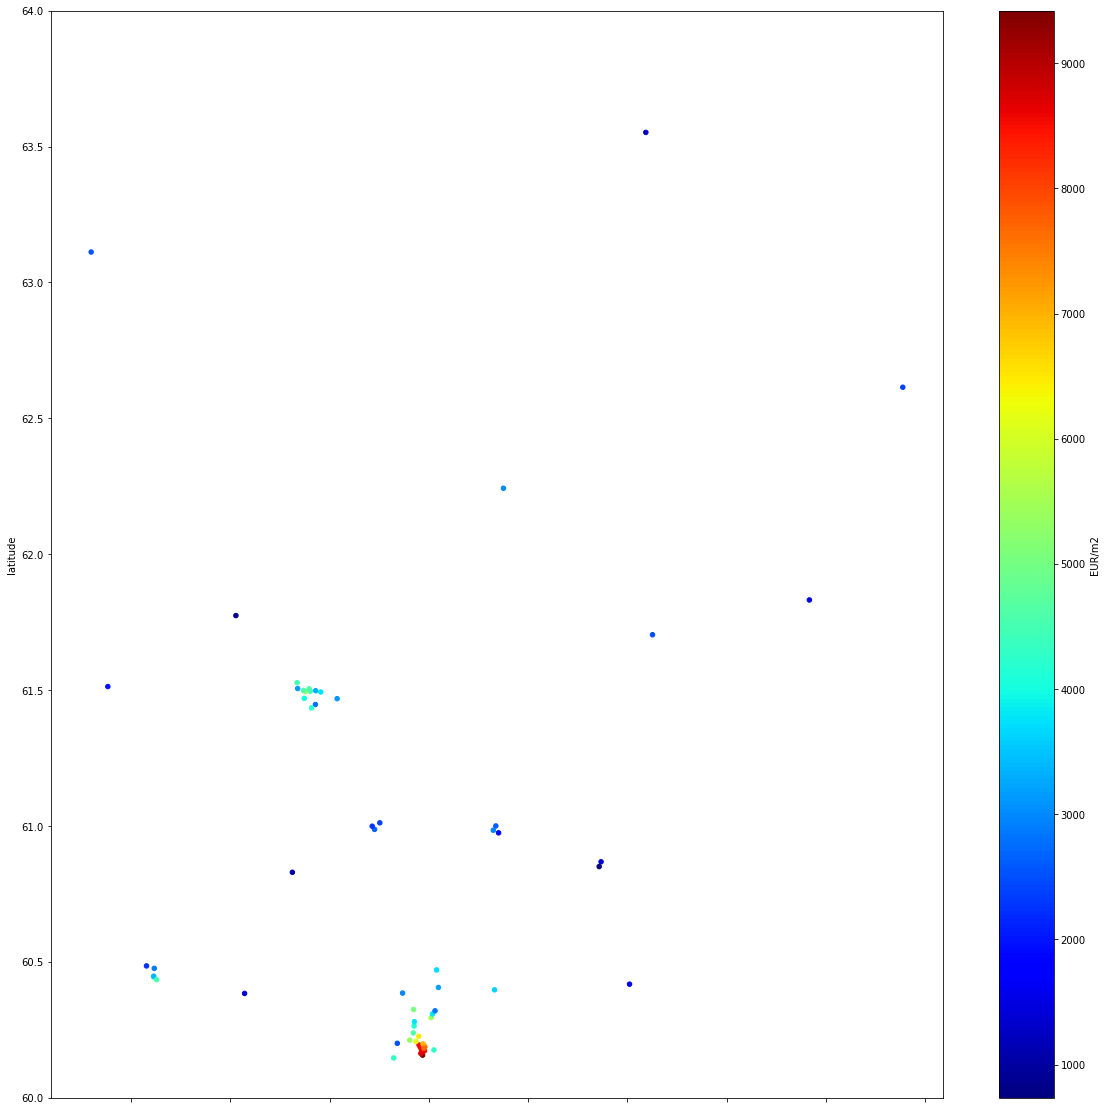

In [9]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=1, figsize=(20,20),
 c="EUR/m2", cmap=plt.get_cmap("jet"), colorbar=True, ylim=(60,64)
)

### Lets test in practice

Lets select the "most nearest postal code" for each postal code. After this, lets compare how well the model of "most nearest postal code" can predict prices for postal code. 

In [10]:
# Lets found nearest place for each postal code
import numpy as np

df_full = df.dropna()
nearest_postal_code = []
postal_codes = list(df_full["Postal code"])
for pc in postal_codes:
    df_full_copy = df_full.copy()
    remove_original_pc = df_full_copy[df_full_copy["Postal code"] != pc]
    n_pc = find_nearest_postal_code(pc, remove_original_pc)
    nearest_postal_code.append(n_pc)
    
df_full["nearest_postal_code"] = nearest_postal_code
df_full.head(10)

/var/folders/by/przz2wk900jdt2rj4vhw770h0000gn/T/ipykernel_56177/1002548150.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full["nearest_postal_code"] = nearest_postal_code


,Postal code,Building type,Quarter,EUR/m2,Location,place_name,state_name,county_name,latitude,longitude,nearest_postal_code
270,00100,"Blocks of flats, one-room flat",2021-04-01,8596.0,Helsinki Keskusta - Etu-Töölö (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1714,24.9316,00260
1374,00150,"Blocks of flats, one-room flat",2021-04-01,9420.0,Eira - Hernesaari (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1570,24.9369,00100
1926,00170,"Blocks of flats, one-room flat",2021-04-01,8593.0,Kruununhaka (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1728,24.9554,00530
2202,00180,"Blocks of flats, one-room flat",2021-04-01,8684.0,Kamppi - Ruoholahti (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1634,24.9190,00100
3858,00250,"Blocks of flats, one-room flat",2021-04-01,8472.0,Taka-Töölö (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1873,24.9127,00260
4134,00260,"Blocks of flats, one-room flat",2021-04-01,8545.0,Keski-Töölö (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1794,24.9226,00100
4410,00270,"Blocks of flats, one-room flat",2021-04-01,8549.0,Pohjois-Meilahti (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1942,24.9007,00250
6618,00350,"Blocks of flats, one-room flat",2021-04-01,6133.0,Munkkivuori-Niemenmäki (Helsinki ),Helsinki,Uusimaa,Helsinki,60.2075,24.8705,00270
7722,00390,"Blocks of flats, one-room flat",2021-04-01,4584.0,Konala (Helsinki ),Helsinki,Uusimaa,Helsinki,60.2387,24.8427,01600
7998,00400,"Blocks of flats, one-room flat",2021-04-01,6478.0,Pohjois-Haaga (Helsinki ),Helsinki,Uusimaa,Helsinki,60.2265,24.8978,00270


In [11]:
pc_and_npc = df_full[["Postal code", "nearest_postal_code"]].values.tolist()

In [12]:
one_room_only = df_wrangled[df_wrangled["Building type"]
                        .isin(["Blocks of flats, one-room flat"])][["Postal code", "Quarter", "EUR/m2"]].replace('..', np.nan)
prop_df = one_room_only.pivot(index="Quarter", columns="Postal code", values="EUR/m2").reset_index()

In [20]:
# Lets test with 00260
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


def test_nearest_postal_code(df, pc, npc):
    npc_df = df[[npc, "Quarter"]].rename(columns={npc:"y","Quarter":"ds"})
    # Lets assume that we are in Q1 of 2021. Therefore, we left Q2 from training. 
    #Instead of using 00260 last cell for test, lets use 00100 which has 00260 as its nearest_postal_code
    test_pc = df[[pc, "Quarter"]].rename(columns={pc:"y","Quarter":"ds"})[-1:]
    train, test = npc_df[:-1], test_pc
    try:
        prop = Prophet(interval_width=0.95)
        prop.fit(train)
        forecast = prop.predict(test)
        mae = mean_absolute_error(test["y"], forecast["yhat"])
        rmse = math.sqrt(mean_squared_error(test["y"], forecast["yhat"]))
        return mae, rmse
    except:
        return -1, -1

In [21]:
mae_values = []
rmse_values = []
for pan in pc_and_npc:
    print(pan)
    mae, rmse = test_nearest_postal_code(prop_df, pan[0], pan[1])
    mae_values.append(mae)
    rmse_values.append(rmse)

['00100', '00260']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -44.5186
Iteration  1. Log joint probability =    58.2471. Improved by 102.766.
Iteration  2. Log joint probability =    67.7065. Improved by 9.45935.
Iteration  3. Log joint probability =     84.938. Improved by 17.2315.
Iteration  4. Log joint probability =    84.9516. Improved by 0.0136001.
Iteration  5. Log joint probability =    84.9776. Improved by 0.0259312.
Iteration  6. Log joint probability =    90.4244. Improved by 5.44685.
Iteration  7. Log joint probability =    90.4291. Improved by 0.00470312.
Iteration  8. Log joint probability =     90.455. Improved by 0.0259197.
Iteration  9. Log joint probability =    90.4837. Improved by 0.0286307.
Iteration 10. Log joint probability =    90.7883. Improved by 0.304641.
Iteration 11. Log joint probability =    90.9009. Improved by 0.112623.
Iteration 12. Log joint probability =    90.9056. Improved by 0.00469951.
Iteration 13. Log joint probability =    91.1536. Improved by 0.247991.
Iteration 14. Log 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['00150', '00100']

Initial log joint probability = -55.6122
Iteration  1. Log joint probability =    60.6214. Improved by 116.234.
Iteration  2. Log joint probability =    87.8402. Improved by 27.2188.
Iteration  3. Log joint probability =    106.734. Improved by 18.8938.
Iteration  4. Log joint probability =    108.373. Improved by 1.63897.
Iteration  5. Log joint probability =     108.63. Improved by 0.257225.
Iteration  6. Log joint probability =    108.643. Improved by 0.0124154.
Iteration  7. Log joint probability =    108.646. Improved by 0.00323148.
Iteration  8. Log joint probability =     108.73. Improved by 0.0839728.
Iteration  9. Log joint probability =    108.965. Improved by 0.234787.
Iteration 10. Log joint probability =    108.978. Improved by 0.0131513.
Iteration 11. Log joint probability =    109.039. Improved by 0.0614262.
Iteration 12. Log joint probability =    109.066. Improved by 0.0268955.
Iteration 13. Log joint probability =    109.091. Improved by 0.0250636.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['00170', '00530']

Initial log joint probability = -54.6154
Iteration  1. Log joint probability =    30.1586. Improved by 84.774.
Iteration  2. Log joint probability =    116.443. Improved by 86.2842.
Iteration  3. Log joint probability =     116.48. Improved by 0.0375718.
Iteration  4. Log joint probability =    116.506. Improved by 0.0253842.
Iteration  5. Log joint probability =    116.515. Improved by 0.00970367.
Iteration  6. Log joint probability =    116.607. Improved by 0.0914874.
Iteration  7. Log joint probability =    135.538. Improved by 18.9305.
Iteration  8. Log joint probability =    135.618. Improved by 0.0801404.
Iteration  9. Log joint probability =    135.922. Improved by 0.304187.
Iteration 10. Log joint probability =    136.005. Improved by 0.0831893.
Iteration 11. Log joint probability =     136.03. Improved by 0.0254216.
Iteration 12. Log joint probability =    136.259. Improved by 0.22886.
Iteration 13. Log joint probability =    136.289. Improved by 0.0293219.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['00180', '00100']

Initial log joint probability = -55.6122
Iteration  1. Log joint probability =    60.6214. Improved by 116.234.
Iteration  2. Log joint probability =    87.8402. Improved by 27.2188.
Iteration  3. Log joint probability =    106.734. Improved by 18.8938.
Iteration  4. Log joint probability =    108.373. Improved by 1.63897.
Iteration  5. Log joint probability =     108.63. Improved by 0.257225.
Iteration  6. Log joint probability =    108.643. Improved by 0.0124154.
Iteration  7. Log joint probability =    108.646. Improved by 0.00323148.
Iteration  8. Log joint probability =     108.73. Improved by 0.0839728.
Iteration  9. Log joint probability =    108.965. Improved by 0.234787.
Iteration 10. Log joint probability =    108.978. Improved by 0.0131513.
Iteration 11. Log joint probability =    109.039. Improved by 0.0614262.
Iteration 12. Log joint probability =    109.066. Improved by 0.0268955.
Iteration 13. Log joint probability =    109.091. Improved by 0.0250636.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['00250', '00260']

Initial log joint probability = -44.5186
Iteration  1. Log joint probability =    58.2471. Improved by 102.766.
Iteration  2. Log joint probability =    67.7065. Improved by 9.45935.
Iteration  3. Log joint probability =     84.938. Improved by 17.2315.
Iteration  4. Log joint probability =    84.9516. Improved by 0.0136001.
Iteration  5. Log joint probability =    84.9776. Improved by 0.0259312.
Iteration  6. Log joint probability =    90.4244. Improved by 5.44685.
Iteration  7. Log joint probability =    90.4291. Improved by 0.00470312.
Iteration  8. Log joint probability =     90.455. Improved by 0.0259197.
Iteration  9. Log joint probability =    90.4837. Improved by 0.0286307.
Iteration 10. Log joint probability =    90.7883. Improved by 0.304641.
Iteration 11. Log joint probability =    90.9009. Improved by 0.112623.
Iteration 12. Log joint probability =    90.9056. Improved by 0.00469951.
Iteration 13. Log joint probability =    91.1536. Improved by 0.247991.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['00260', '00100']

Initial log joint probability = -55.6122
Iteration  1. Log joint probability =    60.6214. Improved by 116.234.
Iteration  2. Log joint probability =    87.8402. Improved by 27.2188.
Iteration  3. Log joint probability =    106.734. Improved by 18.8938.
Iteration  4. Log joint probability =    108.373. Improved by 1.63897.
Iteration  5. Log joint probability =     108.63. Improved by 0.257225.
Iteration  6. Log joint probability =    108.643. Improved by 0.0124154.
Iteration  7. Log joint probability =    108.646. Improved by 0.00323148.
Iteration  8. Log joint probability =     108.73. Improved by 0.0839728.
Iteration  9. Log joint probability =    108.965. Improved by 0.234787.
Iteration 10. Log joint probability =    108.978. Improved by 0.0131513.
Iteration 11. Log joint probability =    109.039. Improved by 0.0614262.
Iteration 12. Log joint probability =    109.066. Improved by 0.0268955.
Iteration 13. Log joint probability =    109.091. Improved by 0.0250636.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['00270', '00250']

Initial log joint probability = -54.615
Iteration  1. Log joint probability =    81.9943. Improved by 136.609.
Iteration  2. Log joint probability =      116.4. Improved by 34.4056.
Iteration  3. Log joint probability =    131.216. Improved by 14.8158.
Iteration  4. Log joint probability =    135.414. Improved by 4.19808.
Iteration  5. Log joint probability =     135.63. Improved by 0.216391.
Iteration  6. Log joint probability =    135.685. Improved by 0.0545183.
Iteration  7. Log joint probability =    135.691. Improved by 0.00597055.
Iteration  8. Log joint probability =    135.697. Improved by 0.00639158.
Iteration  9. Log joint probability =    135.724. Improved by 0.0269149.
Iteration 10. Log joint probability =    135.734. Improved by 0.0104163.
Iteration 11. Log joint probability =    135.738. Improved by 0.00357659.
Iteration 12. Log joint probability =     135.74. Improved by 0.00202382.
Iteration 13. Log joint probability =    135.741. Improved by 0.00094

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['00350', '00270']

Initial log joint probability = -53.7154
Iteration  1. Log joint probability =    54.6383. Improved by 108.354.
Iteration  2. Log joint probability =     83.981. Improved by 29.3427.
Iteration  3. Log joint probability =    100.826. Improved by 16.8448.
Iteration  4. Log joint probability =    116.296. Improved by 15.4704.
Iteration  5. Log joint probability =    116.958. Improved by 0.661791.
Iteration  6. Log joint probability =    116.964. Improved by 0.00633667.
Iteration  7. Log joint probability =    116.997. Improved by 0.0328784.
Iteration  8. Log joint probability =    117.017. Improved by 0.0200184.
Iteration  9. Log joint probability =    117.248. Improved by 0.230512.
Iteration 10. Log joint probability =    117.338. Improved by 0.0902487.
Iteration 11. Log joint probability =    117.385. Improved by 0.0469009.
Iteration 12. Log joint probability =    117.579. Improved by 0.194422.
Iteration 13. Log joint probability =    117.686. Improved by 0.106681.
I

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


['00390', '01600']

Initial log joint probability = -61.1203
Iteration  1. Log joint probability =    13.8951. Improved by 75.0154.
Iteration  2. Log joint probability =    34.9146. Improved by 21.0195.
Iteration  3. Log joint probability =    43.2651. Improved by 8.35053.
Iteration  4. Log joint probability =    47.5955. Improved by 4.33038.
Iteration  5. Log joint probability =    48.3881. Improved by 0.792631.
Iteration  6. Log joint probability =    48.4482. Improved by 0.0600785.
Iteration  7. Log joint probability =    48.4895. Improved by 0.0412523.
Iteration  8. Log joint probability =    48.5365. Improved by 0.0469852.
Iteration  9. Log joint probability =    48.5952. Improved by 0.0587291.
Iteration 10. Log joint probability =     48.638. Improved by 0.0428397.
Iteration 11. Log joint probability =    48.6476. Improved by 0.00961278.
Iteration 12. Log joint probability =    48.6542. Improved by 0.00656239.
Iteration 13. Log joint probability =    48.6612. Improved by 0.006987

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['00400', '00270']

Initial log joint probability = -53.7154
Iteration  1. Log joint probability =    54.6383. Improved by 108.354.
Iteration  2. Log joint probability =     83.981. Improved by 29.3427.
Iteration  3. Log joint probability =    100.826. Improved by 16.8448.
Iteration  4. Log joint probability =    116.296. Improved by 15.4704.
Iteration  5. Log joint probability =    116.958. Improved by 0.661791.
Iteration  6. Log joint probability =    116.964. Improved by 0.00633667.
Iteration  7. Log joint probability =    116.997. Improved by 0.0328784.
Iteration  8. Log joint probability =    117.017. Improved by 0.0200184.
Iteration  9. Log joint probability =    117.248. Improved by 0.230512.
Iteration 10. Log joint probability =    117.338. Improved by 0.0902487.
Iteration 11. Log joint probability =    117.385. Improved by 0.0469009.
Iteration 12. Log joint probability =    117.579. Improved by 0.194422.
Iteration 13. Log joint probability =    117.686. Improved by 0.106681.
I

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['00500', '00530']

Initial log joint probability = -54.6154
Iteration  1. Log joint probability =    30.1586. Improved by 84.774.
Iteration  2. Log joint probability =    116.443. Improved by 86.2842.
Iteration  3. Log joint probability =     116.48. Improved by 0.0375718.
Iteration  4. Log joint probability =    116.506. Improved by 0.0253842.
Iteration  5. Log joint probability =    116.515. Improved by 0.00970367.
Iteration  6. Log joint probability =    116.607. Improved by 0.0914874.
Iteration  7. Log joint probability =    135.538. Improved by 18.9305.
Iteration  8. Log joint probability =    135.618. Improved by 0.0801404.
Iteration  9. Log joint probability =    135.922. Improved by 0.304187.
Iteration 10. Log joint probability =    136.005. Improved by 0.0831893.
Iteration 11. Log joint probability =     136.03. Improved by 0.0254216.
Iteration 12. Log joint probability =    136.259. Improved by 0.22886.
Iteration 13. Log joint probability =    136.289. Improved by 0.0293219.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['00510', '00530']

Initial log joint probability = -54.6154
Iteration  1. Log joint probability =    30.1586. Improved by 84.774.
Iteration  2. Log joint probability =    116.443. Improved by 86.2842.
Iteration  3. Log joint probability =     116.48. Improved by 0.0375718.
Iteration  4. Log joint probability =    116.506. Improved by 0.0253842.
Iteration  5. Log joint probability =    116.515. Improved by 0.00970367.
Iteration  6. Log joint probability =    116.607. Improved by 0.0914874.
Iteration  7. Log joint probability =    135.538. Improved by 18.9305.
Iteration  8. Log joint probability =    135.618. Improved by 0.0801404.
Iteration  9. Log joint probability =    135.922. Improved by 0.304187.
Iteration 10. Log joint probability =    136.005. Improved by 0.0831893.
Iteration 11. Log joint probability =     136.03. Improved by 0.0254216.
Iteration 12. Log joint probability =    136.259. Improved by 0.22886.
Iteration 13. Log joint probability =    136.289. Improved by 0.0293219.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.


['00520', '00510']

Initial log joint probability = -49.1275
Iteration  1. Log joint probability =    44.5888. Improved by 93.7163.
Iteration  2. Log joint probability =    60.0528. Improved by 15.464.
Iteration  3. Log joint probability =    78.1609. Improved by 18.1081.
Iteration  4. Log joint probability =    84.0402. Improved by 5.87928.
Iteration  5. Log joint probability =    84.5829. Improved by 0.542697.
Iteration  6. Log joint probability =    85.3451. Improved by 0.762204.
Iteration  7. Log joint probability =    85.3642. Improved by 0.0190459.
Iteration  8. Log joint probability =    85.3661. Improved by 0.00195685.
Iteration  9. Log joint probability =    85.4197. Improved by 0.0536249.
Iteration 10. Log joint probability =    85.5503. Improved by 0.130546.
Iteration 11. Log joint probability =    85.6047. Improved by 0.0544483.
Iteration 12. Log joint probability =    85.6236. Improved by 0.0188436.
Iteration 13. Log joint probability =    85.6459. Improved by 0.0223.
Iter

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.


['00530', '00510']

Initial log joint probability = -49.1275
Iteration  1. Log joint probability =    44.5888. Improved by 93.7163.
Iteration  2. Log joint probability =    60.0528. Improved by 15.464.
Iteration  3. Log joint probability =    78.1609. Improved by 18.1081.
Iteration  4. Log joint probability =    84.0402. Improved by 5.87928.
Iteration  5. Log joint probability =    84.5829. Improved by 0.542697.
Iteration  6. Log joint probability =    85.3451. Improved by 0.762204.
Iteration  7. Log joint probability =    85.3642. Improved by 0.0190459.
Iteration  8. Log joint probability =    85.3661. Improved by 0.00195685.
Iteration  9. Log joint probability =    85.4197. Improved by 0.0536249.
Iteration 10. Log joint probability =    85.5503. Improved by 0.130546.
Iteration 11. Log joint probability =    85.6047. Improved by 0.0544483.
Iteration 12. Log joint probability =    85.6236. Improved by 0.0188436.
Iteration 13. Log joint probability =    85.6459. Improved by 0.0223.
Iter

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['00840', '00500']

Initial log joint probability = -44.4988
Iteration  1. Log joint probability =    62.6852. Improved by 107.184.
Iteration  2. Log joint probability =    81.7107. Improved by 19.0254.
Iteration  3. Log joint probability =    103.192. Improved by 21.4815.
Iteration  4. Log joint probability =    110.975. Improved by 7.78277.
Iteration  5. Log joint probability =    111.427. Improved by 0.4523.
Iteration  6. Log joint probability =    111.456. Improved by 0.029011.
Iteration  7. Log joint probability =    111.462. Improved by 0.00605806.
Iteration  8. Log joint probability =    111.511. Improved by 0.0487174.
Iteration  9. Log joint probability =    111.511. Improved by 0.000110086.
Iteration 10. Log joint probability =    111.558. Improved by 0.0464236.
Iteration 11. Log joint probability =    111.567. Improved by 0.0099443.
Iteration 12. Log joint probability =    111.597. Improved by 0.029189.
Iteration 13. Log joint probability =    111.604. Improved by 0.00682183.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


['01300', '01350']

Initial log joint probability = -59.8068
Iteration  1. Log joint probability =    18.5775. Improved by 78.3842.
Iteration  2. Log joint probability =      21.06. Improved by 2.4825.
Iteration  3. Log joint probability =    29.7713. Improved by 8.71133.
Iteration  4. Log joint probability =    33.5534. Improved by 3.78208.
Iteration  5. Log joint probability =    36.6372. Improved by 3.08378.
Iteration  6. Log joint probability =    37.0948. Improved by 0.457683.
Iteration  7. Log joint probability =    37.1558. Improved by 0.0609424.
Iteration  8. Log joint probability =    37.2716. Improved by 0.115823.
Iteration  9. Log joint probability =    37.3446. Improved by 0.0729852.
Iteration 10. Log joint probability =    37.5255. Improved by 0.180932.
Iteration 11. Log joint probability =    37.5674. Improved by 0.0418905.
Iteration 12. Log joint probability =    37.5993. Improved by 0.0319005.
Iteration 13. Log joint probability =    37.6085. Improved by 0.00918007.
Ite

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['01350', '01300']

Initial log joint probability = -53.9856
Iteration  1. Log joint probability =    32.1139. Improved by 86.0994.
Iteration  2. Log joint probability =     71.636. Improved by 39.5222.
Iteration  3. Log joint probability =    90.1107. Improved by 18.4747.
Iteration  4. Log joint probability =    90.1609. Improved by 0.0501724.
Iteration  5. Log joint probability =    90.1859. Improved by 0.0250242.
Iteration  6. Log joint probability =    90.2278. Improved by 0.0418886.
Iteration  7. Log joint probability =     90.249. Improved by 0.0211877.
Iteration  8. Log joint probability =    90.5526. Improved by 0.30357.
Iteration  9. Log joint probability =    90.7829. Improved by 0.230361.
Iteration 10. Log joint probability =    101.572. Improved by 10.7894.
Iteration 11. Log joint probability =    104.176. Improved by 2.60391.
Iteration 12. Log joint probability =     104.49. Improved by 0.313684.
Iteration 13. Log joint probability =    104.852. Improved by 0.36206.
Iterat

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


['01360', '01350']

Initial log joint probability = -59.8068
Iteration  1. Log joint probability =    18.5775. Improved by 78.3842.
Iteration  2. Log joint probability =      21.06. Improved by 2.4825.
Iteration  3. Log joint probability =    29.7713. Improved by 8.71133.
Iteration  4. Log joint probability =    33.5534. Improved by 3.78208.
Iteration  5. Log joint probability =    36.6372. Improved by 3.08378.
Iteration  6. Log joint probability =    37.0948. Improved by 0.457683.
Iteration  7. Log joint probability =    37.1558. Improved by 0.0609424.
Iteration  8. Log joint probability =    37.2716. Improved by 0.115823.
Iteration  9. Log joint probability =    37.3446. Improved by 0.0729852.
Iteration 10. Log joint probability =    37.5255. Improved by 0.180932.
Iteration 11. Log joint probability =    37.5674. Improved by 0.0418905.
Iteration 12. Log joint probability =    37.5993. Improved by 0.0319005.
Iteration 13. Log joint probability =    37.6085. Improved by 0.00918007.
Ite

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


['01600', '01620']

Initial log joint probability = -58.3888
Iteration  1. Log joint probability =    21.1399. Improved by 79.5287.
Iteration  2. Log joint probability =    31.2077. Improved by 10.0678.
Iteration  3. Log joint probability =    40.8321. Improved by 9.6244.
Iteration  4. Log joint probability =    46.1477. Improved by 5.31552.
Iteration  5. Log joint probability =    46.4388. Improved by 0.291151.
Iteration  6. Log joint probability =    46.4534. Improved by 0.0145579.
Iteration  7. Log joint probability =    46.4749. Improved by 0.0214898.
Iteration  8. Log joint probability =    46.4756. Improved by 0.000701499.
Iteration  9. Log joint probability =    46.4892. Improved by 0.0136756.
Iteration 10. Log joint probability =    46.4938. Improved by 0.00457003.
Iteration 11. Log joint probability =    46.4995. Improved by 0.00572046.
Iteration 12. Log joint probability =    46.4998. Improved by 0.000264834.
Iteration 13. Log joint probability =    46.4998. Improved by 3.511

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


['01620', '01600']

Initial log joint probability = -61.1203
Iteration  1. Log joint probability =    13.8951. Improved by 75.0154.
Iteration  2. Log joint probability =    34.9146. Improved by 21.0195.
Iteration  3. Log joint probability =    43.2651. Improved by 8.35053.
Iteration  4. Log joint probability =    47.5955. Improved by 4.33038.
Iteration  5. Log joint probability =    48.3881. Improved by 0.792631.
Iteration  6. Log joint probability =    48.4482. Improved by 0.0600785.
Iteration  7. Log joint probability =    48.4895. Improved by 0.0412523.
Iteration  8. Log joint probability =    48.5365. Improved by 0.0469852.
Iteration  9. Log joint probability =    48.5952. Improved by 0.0587291.
Iteration 10. Log joint probability =     48.638. Improved by 0.0428397.
Iteration 11. Log joint probability =    48.6476. Improved by 0.00961278.
Iteration 12. Log joint probability =    48.6542. Improved by 0.00656239.
Iteration 13. Log joint probability =    48.6612. Improved by 0.006987

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


['01700', '01620']

Initial log joint probability = -58.3888
Iteration  1. Log joint probability =    21.1399. Improved by 79.5287.
Iteration  2. Log joint probability =    31.2077. Improved by 10.0678.
Iteration  3. Log joint probability =    40.8321. Improved by 9.6244.
Iteration  4. Log joint probability =    46.1477. Improved by 5.31552.
Iteration  5. Log joint probability =    46.4388. Improved by 0.291151.
Iteration  6. Log joint probability =    46.4534. Improved by 0.0145579.
Iteration  7. Log joint probability =    46.4749. Improved by 0.0214898.
Iteration  8. Log joint probability =    46.4756. Improved by 0.000701499.
Iteration  9. Log joint probability =    46.4892. Improved by 0.0136756.
Iteration 10. Log joint probability =    46.4938. Improved by 0.00457003.
Iteration 11. Log joint probability =    46.4995. Improved by 0.00572046.
Iteration 12. Log joint probability =    46.4998. Improved by 0.000264834.
Iteration 13. Log joint probability =    46.4998. Improved by 3.511

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.


['01800', '01700']

Initial log joint probability = -8.67545


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


['02320', '02760']Iteration  1. Log joint probability =    5.47365. Improved by 14.1491.
Iteration  2. Log joint probability =     10.781. Improved by 5.30731.
Iteration  3. Log joint probability =    13.9434. Improved by 3.16249.
Iteration  4. Log joint probability =    14.9058. Improved by 0.96233.
Iteration  5. Log joint probability =    15.5611. Improved by 0.655336.
Iteration  6. Log joint probability =     17.729. Improved by 2.16792.
Iteration  7. Log joint probability =    20.7525. Improved by 3.02351.
Iteration  8. Log joint probability =    23.2968. Improved by 2.5443.
Iteration  9. Log joint probability =    25.0798. Improved by 1.78296.
Iteration 10. Log joint probability =    32.0417. Improved by 6.96188.
Iteration 11. Log joint probability =    34.4781. Improved by 2.43647.
Iteration 12. Log joint probability =    36.3318. Improved by 1.85361.
Iteration 13. Log joint probability =    39.0751. Improved by 2.74337.
Iteration 14. Log joint probability =    40.0202. Improved 

Iteration 795. Log joint probability =    109.714. Improved by 9.09047e-05.
Iteration 796. Log joint probability =    109.714. Improved by 9.07137e-05.
Iteration 797. Log joint probability =    109.714. Improved by 9.06887e-05.
Iteration 798. Log joint probability =    109.714. Improved by 9.05774e-05.
Iteration 799. Log joint probability =    109.714. Improved by 9.04676e-05.
Iteration 800. Log joint probability =    109.714. Improved by 9.0354e-05.
Iteration 801. Log joint probability =    109.714. Improved by 9.0287e-05.
Iteration 802. Log joint probability =    109.715. Improved by 9.01314e-05.
Iteration 803. Log joint probability =    109.715. Improved by 9.00289e-05.
Iteration 804. Log joint probability =    109.715. Improved by 8.9983e-05.
Iteration 805. Log joint probability =    109.715. Improved by 8.99177e-05.
Iteration 806. Log joint probability =    109.715. Improved by 8.98111e-05.
Iteration 807. Log joint probability =    109.715. Improved by 8.96892e-05.
Iteration 808. 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 2.


['02600', '00390']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['02760', '02320']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['04200', '04400']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


['04400', '04200']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


['06100', '04200']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


['13100', '13130']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['13130', '13100']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['13210', '13100']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.


['15110', '15210']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.


['15150', '15210']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


['15210', '15110']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.


['20100', '20200']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['20200', '20100']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.


['20320', '20200']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['20810', '20100']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['21200', '20320']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


['24100', '30100']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


['28100', '21200']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.


['30100', '33870']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


['33200', '33230']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['33230', '33200']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


['33270', '33400']
['33400', '33270']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


['33500', '33540']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


['33540', '33500']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['33560', '33720']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


['33580', '33560']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.


['33720', '33870']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['33870', '33720']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['33900', '33200']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


['36200', '33580']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.


['39500', '33400']
['40100', '15210']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 0.


['45100', '45150']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


['45150', '45100']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 0.


['48100', '45150']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


['50100', '45100']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


['57100', '80100']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.


['65200', '28100']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


['74100', '50100']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 5.


['80100', '57100']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 0.


['90100', '90570']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.


['90570', '90100']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 0.


['94100', '90570']


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


['96300', '94100']


In [23]:
import statistics

def show_results(data, mae_values, rmse_values,postal_code="postal code"):
    avg_rmse = statistics.mean(rmse_values)
    avg_mae = statistics.mean(mae_values)
    data.plot.bar(x=postal_code, subplots=True, figsize=(15,10))
    print('Average MAE: %.3f' % avg_mae)
    print('Average RMSE: %.3f' % avg_rmse)
    data.describe()

Average MAE: 1810.005
Average RMSE: 1810.005


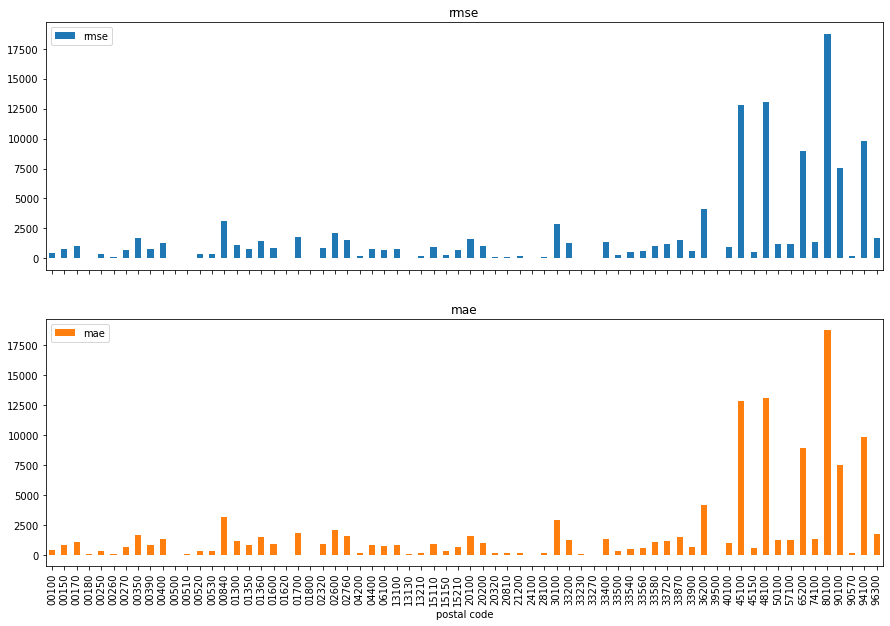

In [24]:
postal_codes = [p[0] for p in pc_and_npc]
data = pd.DataFrame({"postal code":postal_codes, "rmse":rmse_values, "mae":mae_values })
show_results(data, mae_values, rmse_values)

#### Lets compare our results with randomly trained models
